# 3.2. Embeddings

According to [multiple estimates](https://mitsloan.mit.edu/ideas-made-to-matter/tapping-power-unstructured-data), 80% of data generated by businesses today is unstructured data such as text, images, or audio. This data has enormous potential for machine learning applications, but there is _some_ work to be done before it can be used directly.

Embeddings are the backbone of our system. Our goal is to understand how different embeddings or ways of using embeddings impact relevancy of the returned results for a given query.

📝**Hypothesis**

The hypothesis for this experiment is an exploratory one: "Can introducing a new word embedding method improve the system's performance?"

🎯 **Measure of Success**

As we highlighted in the `Chapter 3. Experiments`, our system has two components: the retrieval and the generative one. Take a moment to think what would be the part that would be impacted if we change the embedding model?

<details markdown="1">
<summary> Hint:</summary>

Well, embeddings are used for transforming the input query from plain text into a vector, as well as for vectorizing the documents we have in our index. Therefore, it contributes to how well the system can retrieve relevant documents based on the input query and the documents. In other words, the retrieval component.

</details>

<!-- <details markdown="1">
<summary> Here’s how to connect to your AKS cluster:</summary>

```sh
AKS_NAME=$(az aks list -g "$ENV_RESOURCE_GROUP_NAME" --query "[0].name" -o tsv)
az aks get-credentials \
--resource-group "$ENV_RESOURCE_GROUP_NAME" \
--name "$AKS_NAME"
```

</details> -->


## 👀 Get to know the data

Before we try out different embedding models, let's first try to understand the data. In what follows, you will see the data being clustered and keywords extracted from each cluster. To accomplish this, we performed Dimensionality Reduction, using [t-SNE](https://towardsdatascience.com/what-why-and-how-of-t-sne-1f78d13e224d). If you want to see the code we've been using to accomplish this, go to [t-SNE.ipynb](./helpers/t-SNE.ipynb). Note: in this experiment, we work with the dataset found at `chunks-solution-ops-200-300-0`


Determine the optimal number of clusters
The optimum cluster number is 5 



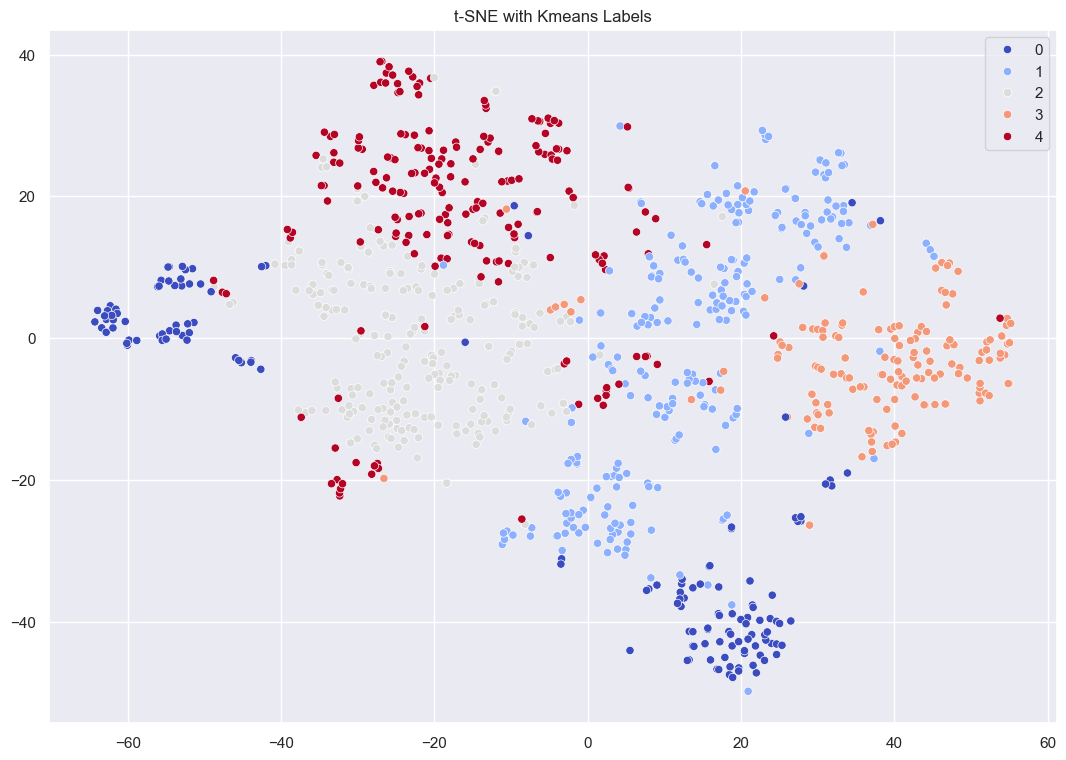

Generate word clouds per cluster
Cluster 1's Keywords:


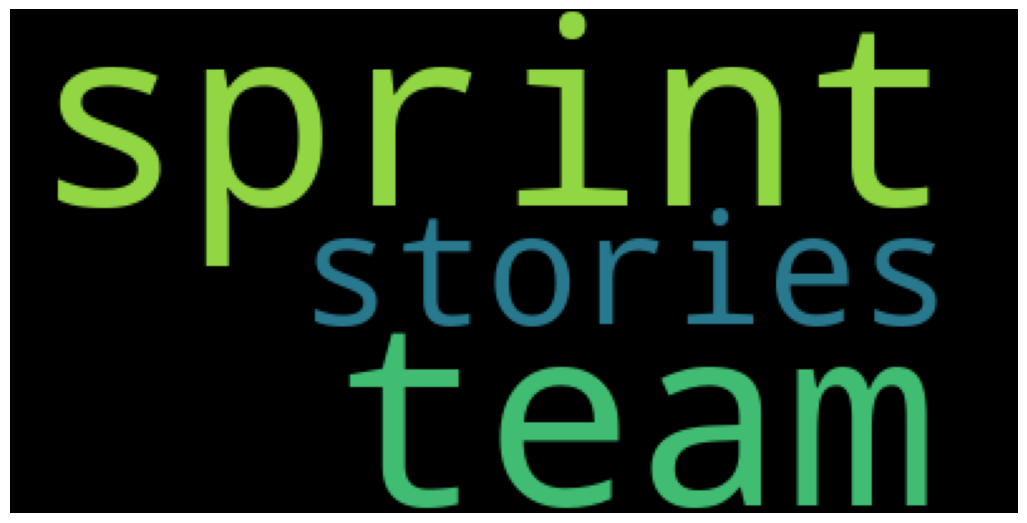

Cluster 2's Keywords:


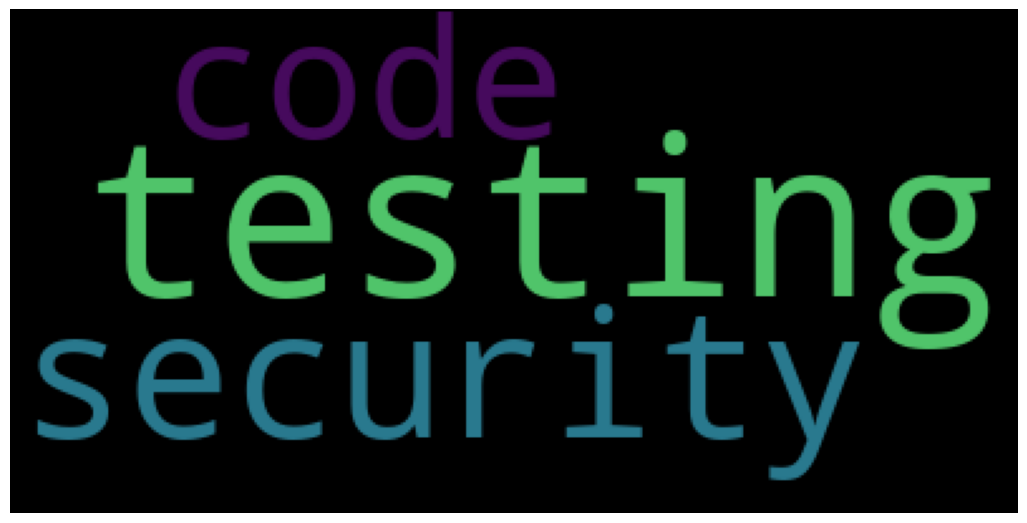

Cluster 3's Keywords:


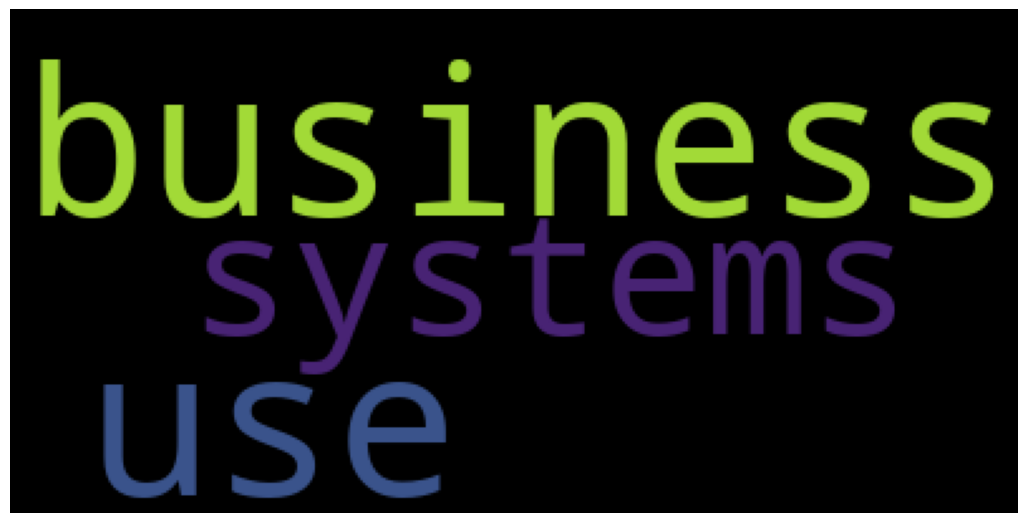

Cluster 4's Keywords:


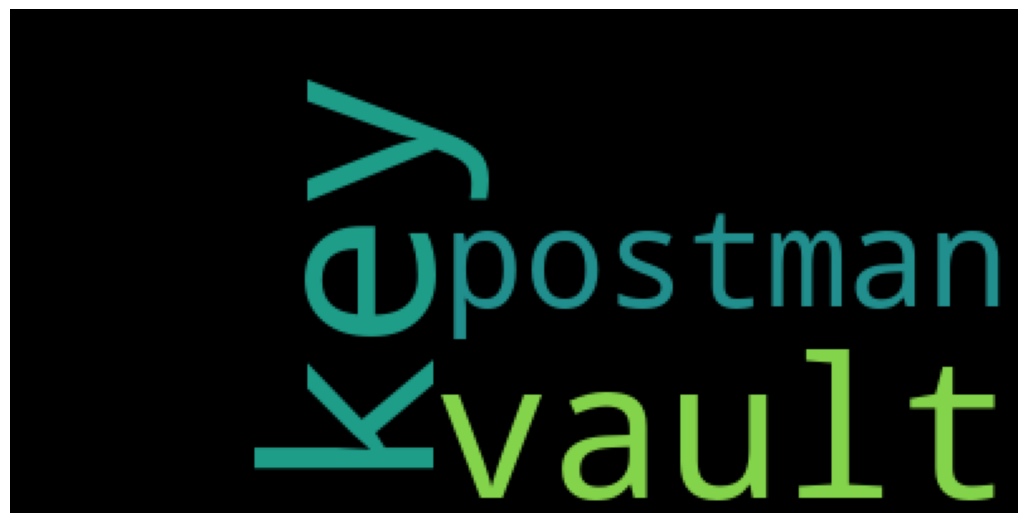

Cluster 5's Keywords:


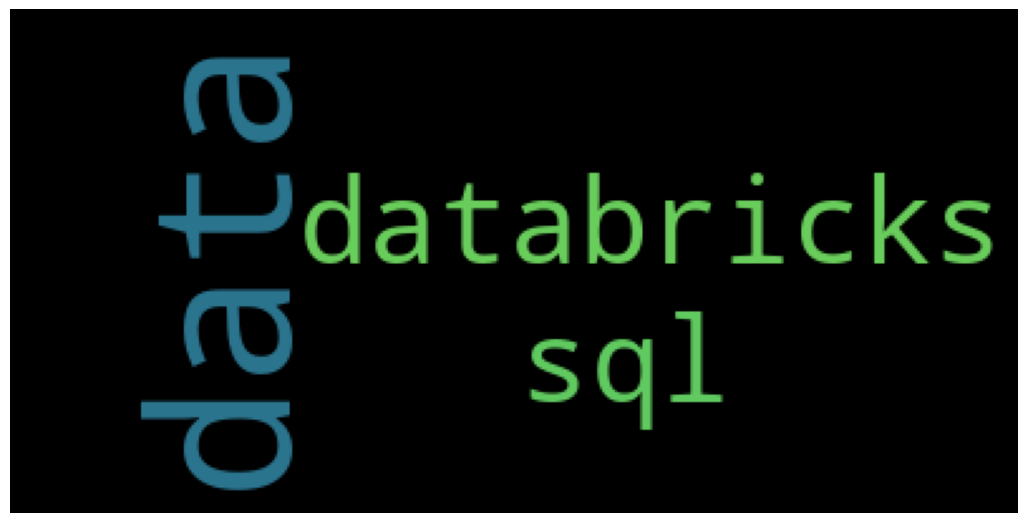

<Figure size 1300x900 with 0 Axes>

In [135]:
%run -i ./helpers/t-SNE.ipynb

```{note}

```

As we have seen from the cluster from above, the data `can` be clustered, and the clusters seem to be different from one another. One is centered on data (sql, databricks) vs backlog related (stories, sprint, team) vs engineering fundamentals (security, testing, code). However, if we think about these clusters on a broader sense, they are part of one big cluster, which is IT.

## Which Embeddings Model to use?

There are several embedding options:

- OpenAI models, such as: [`text-embedding-ada-002`](https://platform.openai.com/docs/guides/embeddings/what-are-embeddings), `text-embedding-3-small`, `text-embedding-3-large`
- HuggingFace models, which offers a wide range of models. The [MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard) ranks the performance of embeddings models on a few axis, though not all models can be run locally.

### a) Embed a query using an embedding model from OpenAI


In [138]:
import os
import dotenv

%reload_ext dotenv
%dotenv

aoai_endpoint = os.environ["aoai_endpoint"]
aoi_api_key = os.environ["aoi_api_key"]


In [139]:
import requests

def get_query_embedding(
    query,
    endpoint=aoai_endpoint,
    api_key=aoi_api_key,
    api_version="2023-07-01-preview",
    embedding_model_deployment=embedding_model_name,
):
    request_url = f"{endpoint}/openai/deployments/{embedding_model_deployment}/embeddings?api-version={api_version}"
    headers = {"Content-Type": "application/json", "api-key": api_key}
    request_payload = {"input": query}
    embedding_response = requests.post(
        request_url, json=request_payload, headers=headers, timeout=None
    )
    if embedding_response.status_code == 200:
        data_values = embedding_response.json()["data"]
        embeddings_vectors = [data_value["embedding"] for data_value in data_values]
        return embeddings_vectors
    else:
        raise Exception(f"failed to get embedding: {embedding_response.json()}")

NameError: name 'embedding_model_name' is not defined

### See the embedded result for one query

Feel free to update the `query` variable


In [ ]:
query = "Hello"

query_vectors = get_query_embedding(
    query, aoai_endpoint, aoi_api_key, "2023-07-01-preview", embedding_model_name
)

print(f"The embedded vector is: {query_vectors[0]}")
print(f"The length of the embedding is: {len(query_vectors[0])}")

### Embed the chunks and save to a file


In [129]:
def generate_embeddings_for_chunks(totalNumberOfDocuments):
    path_to_file = f"./output/chunks-solution-ops-embedded-{totalNumberOfDocuments}.json"
    if(os.path.exists(path_to_file)):
        print(f"Embeddings were already created for chunked data at: {path_to_file} ")
        return
    with open(f"./output/chunks-solution-ops-{totalNumberOfDocuments}.json", "r", encoding="utf-8") as file:
        input_data = json.load(file)
        for chunk in input_data:
            content = chunk["chunkContent"]
            content_emebddings = get_query_embedding(content)[0]
            chunk["chunkContentVector"] = content_emebddings
    print(f"Created {len(input_data)} chunks")
    print(f"Example of one chunk: {input_data[1]}")

    with open("./output/chunks-solution-ops-embedded-{totalNumberOfDocuments}.json", "w") as f:
        json.dump(input_data, f)

In [130]:
totalNumberOfDocuments = 200
generate_embeddings_for_chunks(totalNumberOfDocuments)

Embeddings were already created for chunked data at: ./output/chunks-solution-ops-embedded-200.json 


### b) Embed a query using an embedding model from Hugging Face

We will use [`infloat/e5-small-v2`](https://huggingface.co/intfloat/e5-small-v2) from Hugging Face, which is of size 0.13 GB.


In [131]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("intfloat/e5-small-v2")
query = "Hello"

embedded_query = model.encode(query, normalize_embeddings=True)
print(len(embedded_query))

c:\Projects\Workshop2024\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


384


In [132]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("intfloat/e5-small-v2")

with open("./data/text-sample.json", "r", encoding="utf-8") as file:
    input_data = json.load(file)

for item in input_data:
    title = item["title"]
    content = item["content"]
    title_embeddings = model.encode(title, normalize_embeddings=True)
    content_embeddings = model.encode(content, normalize_embeddings=True)
    item["titleVector"] = title_embeddings.tolist()
    item["contentVector"] = content_embeddings.tolist()

with open("./output/docVectors-e5.json", "w") as f:
    json.dump(input_data, f)

KeyboardInterrupt: 